# Neural Network with PyTorch

In PyTorch you can implement neural network with the `torch.nn` module

In this notebook we are going to implement a simple example classifier on the XOR dataset. 

The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function. Hence, we will learn how to build a small neural network that can learn this function. 

*This notebook is inspired by the [UVA Deep Learning Course](https://uvadlc-notebooks.readthedocs.io/en/latest/index.html)*

[<img src="https://img.shields.io/badge/Status-Progress-blue.svg?logo=LOGO">](<LINK>)

# Intro to Neural Networks

Neural networks are a family of 
- `Parametric`
- `Non linear`

functions that can be optimized with stochastic gradient descent to encode domain knowledge.

Mathematically a neural network can be described with the following notation:

$a_L(x; \theta_{1, \cdots, L}) = h_L(h_{L-1}(\cdots(h_L(x,\theta_1)\cdots))\theta_{L-1}),\theta_L)$  

This notation can be simplified as:

$a_L = h_L \circ h_{L-1} \circ \cdots \circ h_1 \circ x$ 

Where all the functions $h_l$ have a parameter $\theta_l$.

Alternatively we can use a graphical representation of a neural network:

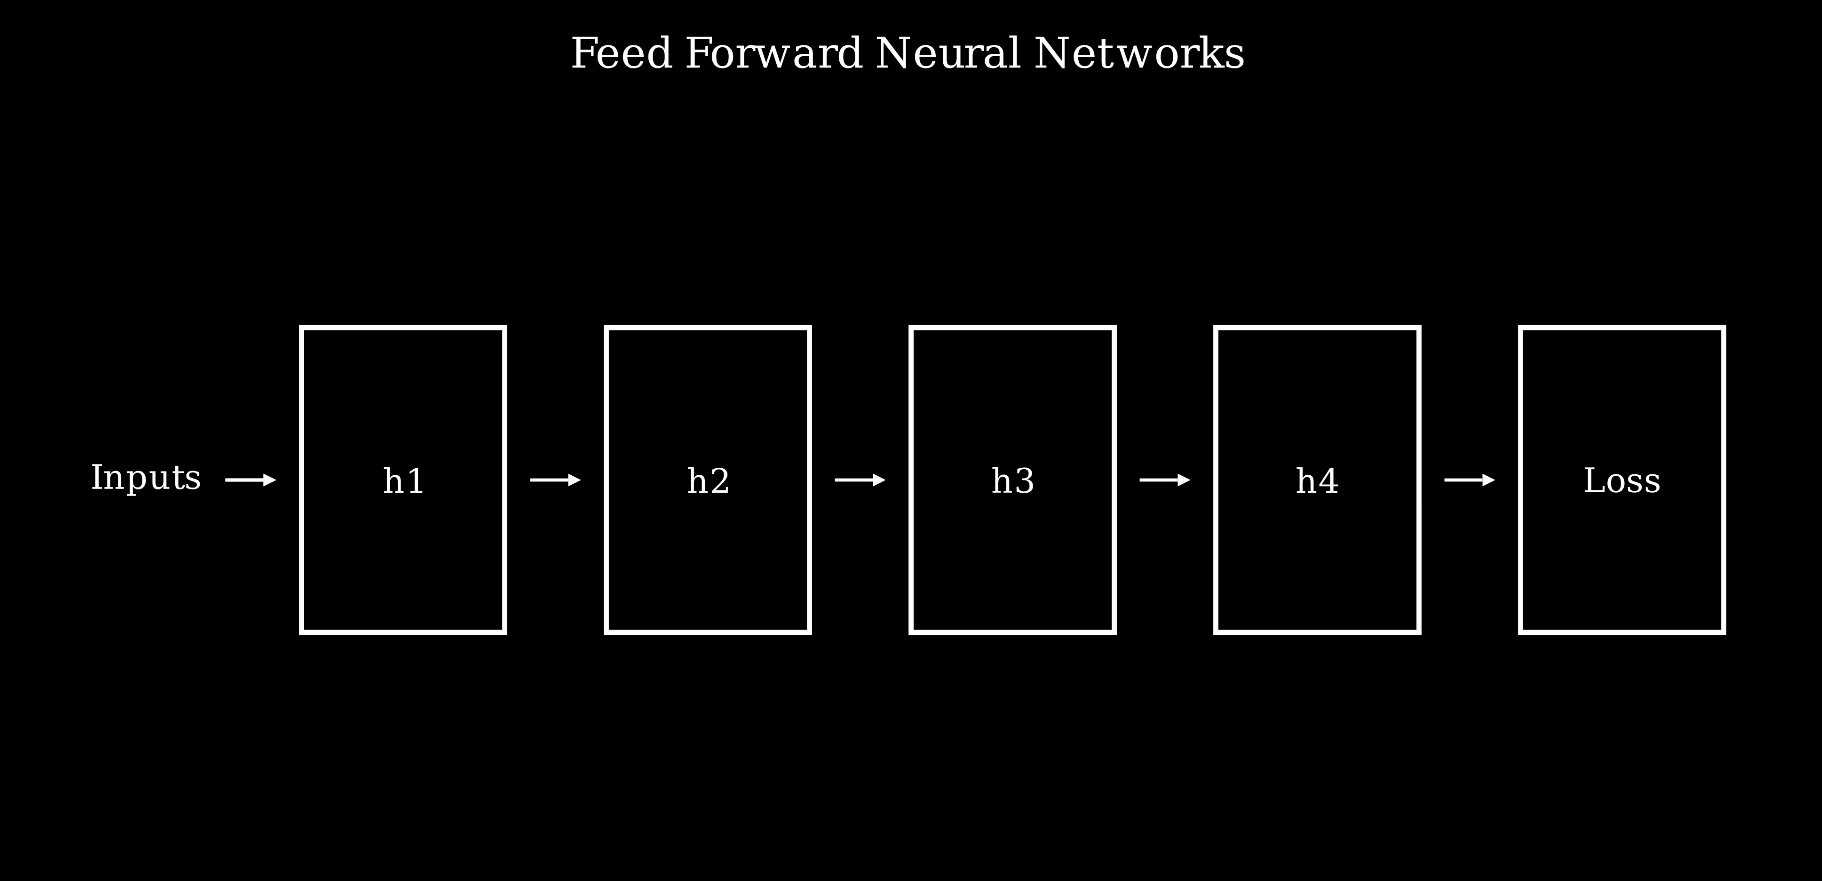

The input $\mathbf{x}$ now is represented by the *inputs*.

The first block corresponds to the first function, the second block to the second function and so on. The last block returns the prediction of the neural network. We can compare the prediction with the ground truth using a loss function.

To adjust the predictions of the neural network we use use a technique knows as `backpropagation` which is a way of propagating the total loss back into the neural network to know how much of the loss every node is responsible for, and subsequently updating the weights in a way that minimizes the loss.

---
# Import section

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import seaborn as sns
sns.set_style('darkgrid')

from tqdm.notebook import tqdm

import torch

import torch.nn as nn # Defines a series of classes to implement neural nets
import torch.nn.functional as F # Contains functions that are used in network layers

---
# Implementing a nn.Module

In PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:

In [2]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        # Initializations
            
    def forward(self, x):
        # Function to perform the calculations
        pass

Let's try to implement a simple classifier with 2 input neurons, 4 hidden neurons and 1 output

In [3]:
class SimpleClassifier(nn.Module):
    
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        
        return x

In [4]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


Printing the model lists all submodules it contains. The parameters of a module can be obtained by using its parameters() functions, or named_parameters() to get a name to each parameter object. For our small neural network, we have the following parameters:

In [5]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


# Datasets in Pytorch

In [6]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

## The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the 
-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [7]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [8]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.0268, 1.2588]), tensor(1))


In [9]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(8,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

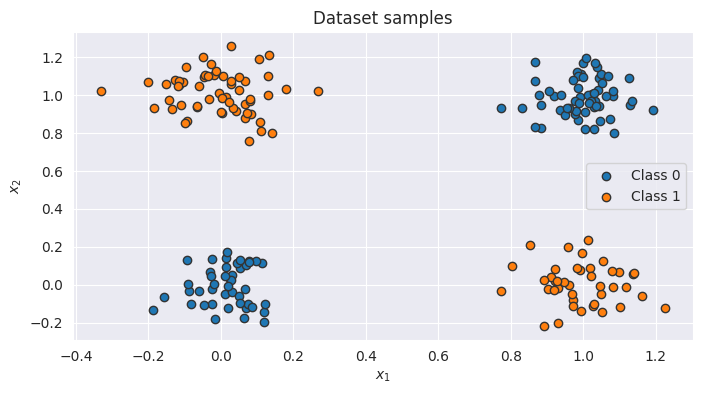

In [10]:
visualize_samples(dataset.data, dataset.label)
plt.show()

 ## The dataloader class

The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch.

`batch_size`: Number of samples to stack per batch

`shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity.

`num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.

`pin_memory`: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.

`drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.

In [11]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [12]:
# next(iter(...)) catches the first batch of the data loader
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 1.1250,  1.0931],
        [ 0.1326,  1.2128],
        [-0.1155,  1.0521],
        [ 0.8828,  0.8270],
        [ 1.0330,  0.9722],
        [-0.0315,  0.9822],
        [ 0.9177, -0.0295],
        [ 1.0813, -0.0109]])
Data labels torch.Size([8]) 
 tensor([0, 1, 1, 0, 0, 1, 1, 1])


## Training the model

During training we will perform the following operations:
1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the negative gradients

In [13]:
# Implementing the loss module and the optimizer
loss_module = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [14]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
model.to(device)

Device: cpu


SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [18]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device 
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model 
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], reshape into [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

In [19]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

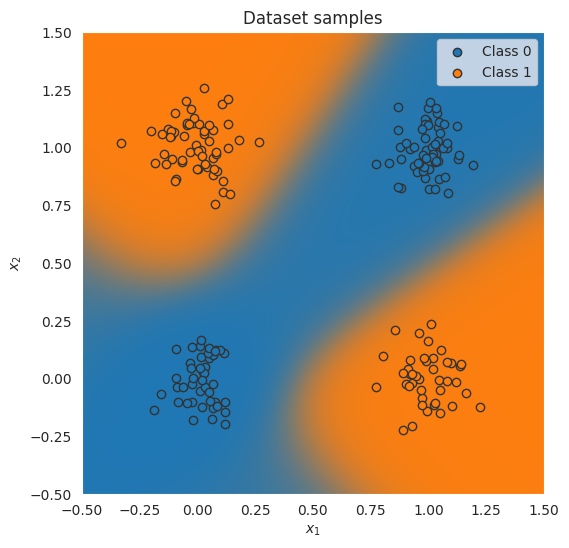

In [20]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(6,6))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

## Evaluation

In [21]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [22]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [23]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


### Removing the hidden layer

The XOR operator is a non linear operator, hence we can't classify the points in the correct class with a simple linear regression. 

If we remove the hidden layer and the activation function we will see that the accuracy of the model drops:

In [24]:
class Perceptron(nn.Module):
    
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_outputs)
        self.act_fn = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        
        return x

In [25]:
perceptron = Perceptron(num_inputs=2, num_outputs=1)

In [26]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
perceptron.to(device)

Device: cpu


Perceptron(
  (linear1): Linear(in_features=2, out_features=1, bias=True)
  (act_fn): Sigmoid()
)

In [28]:
train_model(perceptron, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
eval_model(perceptron, test_data_loader)

Accuracy of the model: 52.40%


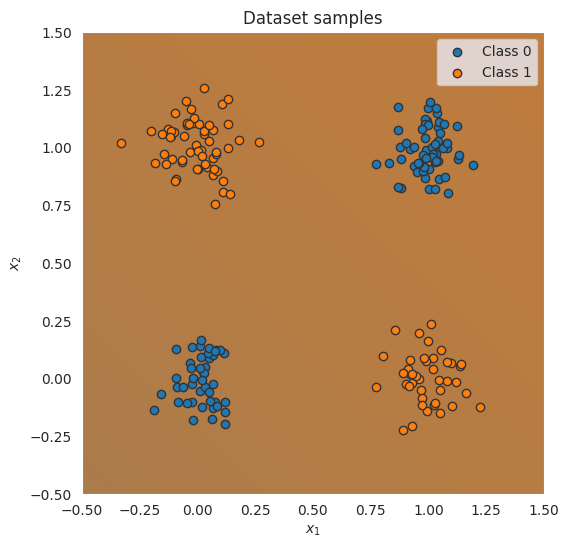

In [30]:
_ = visualize_classification(perceptron, dataset.data, dataset.label)
plt.show()

 ## Saving the model

In [31]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[ 2.3944,  2.4238],
        [ 3.3259, -2.3546],
        [-2.1653,  3.1869],
        [-0.6587,  1.4867]])), ('linear1.bias', tensor([-0.5366,  0.8053,  0.7549,  0.1200])), ('linear2.weight', tensor([[ 3.5634, -4.5025, -3.8110, -1.1254]])), ('linear2.bias', tensor([1.3538]))])


In [32]:
# torch.save(object, filename)
torch.save(state_dict, "model.tar")

In [33]:
 #Load state dict from the disk
state_dict = torch.load("model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[ 2.3944,  2.4238],
        [ 3.3259, -2.3546],
        [-2.1653,  3.1869],
        [-0.6587,  1.4867]])), ('linear1.bias', tensor([-0.5366,  0.8053,  0.7549,  0.1200])), ('linear2.weight', tensor([[ 3.5634, -4.5025, -3.8110, -1.1254]])), ('linear2.bias', tensor([1.3538]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[ 2.3944,  2.4238],
        [ 3.3259, -2.3546],
        [-2.1653,  3.1869],
        [-0.6587,  1.4867]])), ('linear1.bias', tensor([-0.5366,  0.8053,  0.7549,  0.1200])), ('linear2.weight', tensor([[ 3.5634, -4.5025, -3.8110, -1.1254]])), ('linear2.bias', tensor([1.3538]))])
